<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

Where else but Quora can a physicist help a chef with a math problem and get cooking tips in return? Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

Currently, Quora uses a Random Forest model to identify duplicate questions. In this competition, Kagglers are challenged to tackle this natural language processing problem by applying advanced techniques to classify whether question pairs are duplicates or not. Doing so will make it easier to find high quality answers to questions resulting in an improved experience for Quora writers, seekers, and readers.

-Kaggle : https://www.kaggle.com/c/quora-question-pairs/


<h2> 1.2 Data fields <h2>



    id - the id of a training set question pair
    qid1, qid2 - unique ids of each question (only available in train.csv)
    question1, question2 - the full text of each question
    is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.


<h3> 1.3 Performance Metric(s) <h3>


* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h3> 1.4 Type of Problem <h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h1> 3. Exploratory Data Analysis

<h3> 3.1 Importing all libraries <h3>

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from bs4 import BeautifulSoup
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# from pycontractions import Contractions
from fuzzywuzzy import fuzz
from tqdm import tqdm
import distance

from collections import Counter
from wordcloud import WordCloud, STOPWORDS
# import pattern.en as en
from sklearn.feature_extraction.text import CountVectorizer
import spacy

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## 3.2 Reading the data 

In [24]:
data = pd.read_csv('train.csv')
print(f'Number of data points in train set {data.shape[0]}')

Number of data points in train set 404290


In [25]:
data.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## 3.3 Basic Stats

### 3.3.1 Data information

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


Column question1 has 1 null row and question2 has 2 null rows.


### 3.3.2 Duplicate values percentage


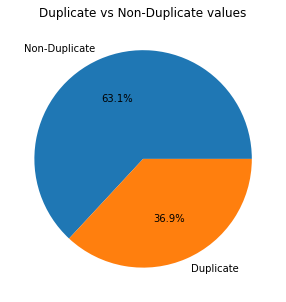

In [27]:
duplicate = data.groupby('is_duplicate')['id'].count()
plt.figure(figsize=(5,5))
plt.pie(duplicate, labels= ['Non-Duplicate','Duplicate'], autopct='%1.1f%%')
plt.title('Duplicate vs Non-Duplicate values')
plt.show()

From above pie chart, our data consist of 63% of data which is labeled Non-duplicate whereas 36.9% of data is labeled duplicate. 

### 3.3.3 Frequency of questions


In [28]:
questions = data['qid1'].tolist() + data['qid2'].tolist()
values = np.unique(questions)

In [29]:
store = {}
values = []

for x in questions:
    if x in store:
        try:
            store[x] += 1 
        except:
            pass
    else:
        store[x] = 1

max_n = store[max(store, key= store.get)]
counts = 0

for x in store.values():
    if x <= 1:
        pass
    else:
        counts += 1
# store is a dict contains questions and their frequcey
# count contains number of questions appear more then once

In [30]:
print(f'Number of unique questions {len(store)}')
print(f'Maximum time a question appears more then once {max_n}')
print(f'Total number question appear more then once {counts}')

Number of unique questions 537933
Maximum time a question appears more then once 157
Total number question appear more then once 111780


<function matplotlib.pyplot.show>

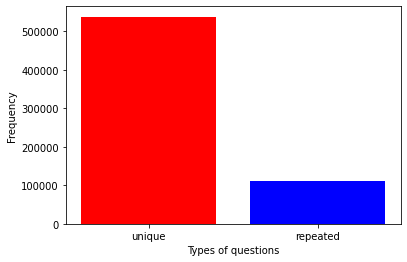

In [31]:
plt.bar(['unique', 'repeated'], [len(store),counts], color=['r','b'])
plt.xlabel('Types of questions')
plt.ylabel('Frequency')
plt.show

Over 500000 questions are unique and 100000 questions are repeated.
 

<function matplotlib.pyplot.show>

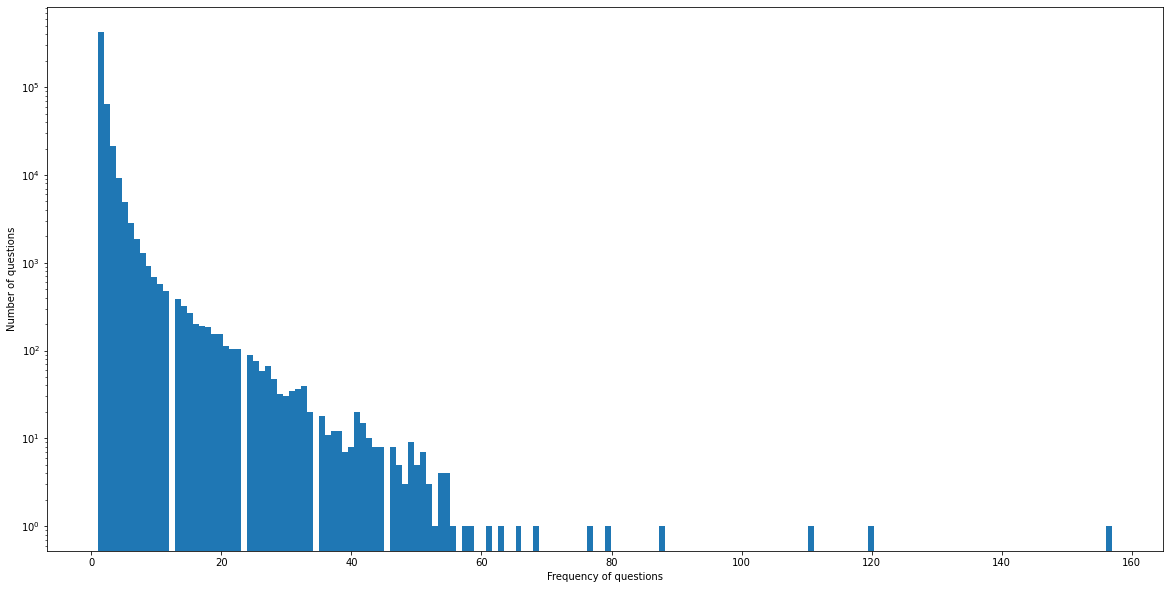

In [32]:
plt.figure(figsize= (20,10))
plt.hist(store.values(), bins = 170)
plt.yscale('log')
plt.xlabel('Frequency of questions')
plt.ylabel('Number of questions')
plt.show

# 4. Feature Engineering


### 4.1 Simple Featues



* freq_qid1 = Frequency of qid1's
* freq_qid2 = Frequency of qid2's
* q1len = Length of q1
* q2len = Length of q2
* q1_n_words = Number of words in Question 1
* q2_n_words = Number of words in Question 2
* word_Common = (Number of common unique words in Question 1 and Question 2)
* word_Total =(Total num of words in 
* Question 1 + Total num of words in Question 2)
* freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
* freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2
* word_share__ = (word_common)/(word_Total)

In [33]:
duplicates = data[data.duplicated(['qid1','qid2'])]
print(f'Number of duplicate rows {duplicates.shape[0]}')

Number of duplicate rows 0


In [34]:
data = data.fillna(' ')

In [35]:
def matcher(a,b):
    """ this function return number of common words in given two questions"""
    a,b = a.lower().strip().split(' '), b.lower().strip().split(' ')
    return len(list(set(a).intersection(b)))

def simple_feat(data):
    data['freq_q1'] = [ store[count] for count in data['qid1']]
    data['freq_q2'] = [ store[count] for count in data['qid2']]
    data['len_q1'] = [len(sent) for sent in data['question1']]
    data['len_q2'] = [len(sent) for sent in data['question2']]
    data['words_q1'] = [len(sent.split(' ')) for sent in data['question1']]
    data['words_q2'] = [len(sent.split(' ')) for sent in data['question2']]
    data['common_words'] = [matcher(sent1,sent2) for sent1, sent2 in zip(data['question1'],data['question2'])]    
    data['total_words'] = [words1 + words2 for words1, words2 in zip(data['words_q1'],data['words_q2'])]
    #data['word_share'] = [1.0 * round(common/len(sent1.lower().strip().split(' '))+len(sent2.lower().strip().split(' ')),2) for sent1, sent2, common in zip(data['question1'],data['question2'],data['common_words'])]
    data["word_share"] = [common_w / total_w for common_w, total_w in zip(data['common_words'], data['total_words'])]
    data['freq_sum'] = [sent1+sent2 for sent1, sent2 in zip(data['freq_q1'],data['freq_q2'])]
    data['freq_dif'] = [sent1-sent2 for sent1, sent2 in zip(data['freq_q1'], data['freq_q2'])]
    data.to_csv("simple_features.csv", index=False)
    return data


In [36]:
simple_feat(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            404290 non-null  int64  
 1   qid1          404290 non-null  int64  
 2   qid2          404290 non-null  int64  
 3   question1     404290 non-null  object 
 4   question2     404290 non-null  object 
 5   is_duplicate  404290 non-null  int64  
 6   freq_q1       404290 non-null  int64  
 7   freq_q2       404290 non-null  int64  
 8   len_q1        404290 non-null  int64  
 9   len_q2        404290 non-null  int64  
 10  words_q1      404290 non-null  int64  
 11  words_q2      404290 non-null  int64  
 12  common_words  404290 non-null  int64  
 13  total_words   404290 non-null  int64  
 14  word_share    404290 non-null  float64
 15  freq_sum      404290 non-null  int64  
 16  freq_dif      404290 non-null  int64  
dtypes: float64(1), int64(14), object(2)
memory usage

In [37]:
print('Question with minimum length in question1', min(data['len_q1']))
print('Question with minimum length in question2', min(data['len_q2']))
print('Question with maximum length in question1', max(data['len_q1']))
print('Question with maximum length in question2', max(data['len_q2']))

Question with minimum length in question1 1
Question with minimum length in question2 1
Question with maximum length in question1 623
Question with maximum length in question2 1169


### 4.2 Data Preprocessing


* Removing html tags 
* Removing Punctuations
* Performing stemming
* Removing Stopwords
* Expanding contractions etc.

In [38]:
def contractions(data):
    """ Regular expressions to expand contractions"""
    data = data.lower().replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    return data

def punctutions(data):
    data = re.sub(r'[^\w\s]', '', data)
    data = re.sub(r"([0-9]+)000000", r"\1m", data)
    data = re.sub(r"([0-9]+)000", r"\1k", data)
    return data

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def stemming(sentence):
    stemmer = PorterStemmer()
    sentence = sentence.split()
    sentence = ' '.join(stemmer.stem(word) for word in sentence ) #if word not in stop_words)
    return sentence


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [39]:
data['question1'] = data['question1'].apply(contractions)
data['question2'] = data['question2'].apply(contractions)
data['question1'] = data['question1'].fillna('').apply(lambda x: BeautifulSoup(x, "lxml").text)
data['question2'] = data['question2'].fillna('').apply(lambda x: BeautifulSoup(x, "lxml").text)
data['question1'] = data['question1'].fillna('').apply(punctutions)
data['question2'] = data['question2'].fillna('').apply(punctutions) 
data['question1'] = data['question1'].fillna('').apply(stemming)
data['question2'] = data['question2'].fillna('').apply(stemming)

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


### 4.3 Advanced Feature Extraction (NLP and Fuzzy Features)

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))

- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


### 4.3.1 Fuzz ratios

In [41]:
data['fuzz_ratio'] = data.apply(lambda x : fuzz.ratio(x['question1'],x['question2']),axis=1)
data['fuzz_partial_ratio'] = data.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
data['token_sort_ratio'] = data.apply(lambda x: fuzz.token_sort_ratio(x['question1'], x['question2']),axis=1)
data['token_set_ratio'] = data.apply(lambda x: fuzz.token_set_ratio(x['question1'],x['question2']),axis=1)

### 4.3.2 Common word and Token ratios


In [42]:
cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, longest_substr_ratio = [],[],[],[],[],[],[],[],[],[],[]

In [43]:

Safe_add = 0.0001 # safe addtion so 0 ratios wont be exactly 0

for x in tqdm(range(int(data.shape[0]))):
    token_1 = data.question1[x].split()
    token_2 = data.question2[x].split()

        # Get non stop words:
    words_1 = set([word for word in token_1 if word not in stop_words])
    words_2 = set([word for word in token_2 if word not in stop_words])

        # Get common stop words:
    stop_q1 = set([word for word in token_1 if word in stop_words])
    stop_q2 = set([word for word in token_2 if word in stop_words])

        # Get the common non-stopwords from Question pair
    common_word_count = len(words_1.intersection(words_2))
        
        # Get the common stopwords from Question pair
    common_stop_count = len(stop_q1.intersection(stop_q2))
        # Get the common Tokens from Question pair
    common_token_count = len(set(token_1).intersection(set(token_2)))
        # Get Ratios 
    cwc_min.append(common_word_count / (min(len(words_1), len(words_2)) + Safe_add))
    cwc_max.append(common_word_count / (max(len(words_1), len(words_2)) + Safe_add))
    csc_min.append(common_stop_count / (min(len(stop_q1), len(stop_q2)) + Safe_add))
    csc_max.append(common_stop_count / (max(len(stop_q1), len(stop_q2)) + Safe_add))
    ctc_min.append(common_token_count / (min(len(token_1),len(token_2)) + Safe_add))
    ctc_max.append(common_token_count / (max(len(token_1),len(token_2)) + Safe_add))
    
        # Check it the last word is equal or not
    if len(token_1)== 0 or len(token_2) == 0:
        last_word_eq.append(0)
    elif token_1[-1] == token_2[-1]:
        last_word_eq.append(1)
    else:
        last_word_eq.append(0)
    
        # Check if the first word is equal or not
    if len(token_1)== 0 or len(token_2) == 0:
        first_word_eq.append(0)
    elif token_1[0] == token_2[0]:
        first_word_eq.append(1)
    else:
        first_word_eq.append(0)
    
        # absolute length diffrence 
    abs_len_diff.append(abs(len(token_1)-len(token_2)))
        # mean length difference
    mean_len.append((len(token_1)+len(token_2) / 2))

        # Longest common substring using distance library
    strs = list(distance.lcsubstrings(data['question1'][x],data['question2'][x]))
    if len(strs) ==0:
        longest_substr_ratio.append(0)
    else:
        longest_substr_ratio.append(len(strs[0])/min(len(data['question1'][x]),len(data['question2'][x])))


100%|██████████| 404290/404290 [04:16<00:00, 1574.67it/s]


In [44]:
data['cwc_min'] = cwc_min
data['cwc_max'] = cwc_max
data['csc_min'] = csc_min
data['csc_max'] = csc_max
data['ctc_min'] = ctc_min
data['ctc_max'] = ctc_max
data['last_word_eq'] = last_word_eq
data['first_word_eq'] = first_word_eq
data['abs_len_diff'] = abs_len_diff
data['mean_len'] = mean_len
data['longest_subs_ratio'] = longest_substr_ratio

# 5.1 Word Cloud

In [47]:
duplicate = data[data['is_duplicate'] == 1]
nonduplicate = data[data['is_duplicate'] == 0]

In [48]:
a = np.dstack([duplicate["question1"], duplicate["question2"]]).flatten()
b = np.dstack([nonduplicate["question1"], nonduplicate["question2"]]).flatten()

In [49]:
stopwords = set(STOPWORDS)
stopwords.add('whi')
stopwords.add('doe')

In [52]:
def cloud(data,count):
    vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = 'english') 
    vectors = vectorizer.fit_transform(data)
    counts = vectors.sum(axis=0).A1
    vocab = list(vectorizer.get_feature_names())
    frequency = Counter(dict(zip(vocab, counts)))
    frequency_2 = frequency.most_common(count)
    words = ' '.join(x[0] for x in frequency_2)
    wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10,stopwords=stopwords).generate(words) 
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 

## 5.1.1 Duplicate question cloud

Top Words in Duplicate Questions


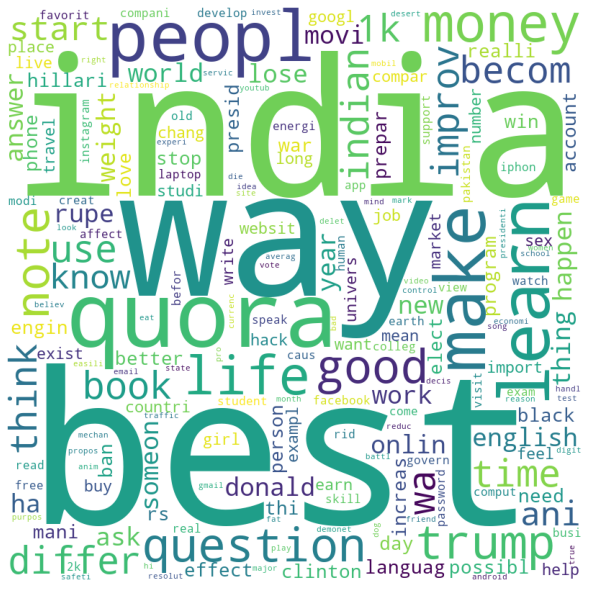

In [53]:
print("Top Words in Duplicate Questions")
cloud(a,200)

## 5.1.2 Nonduplicate questions cloud

Top Words in Non-Duplicate Questions


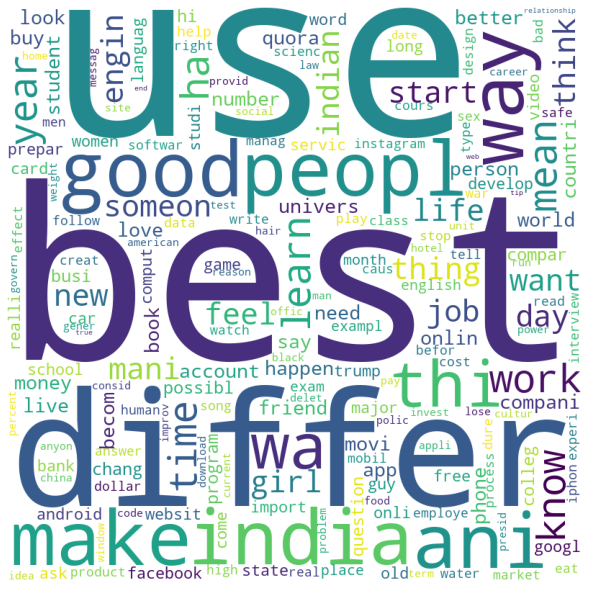

In [54]:
print("Top Words in Non-Duplicate Questions")
cloud(b,200)

## 5.2 Pairplots

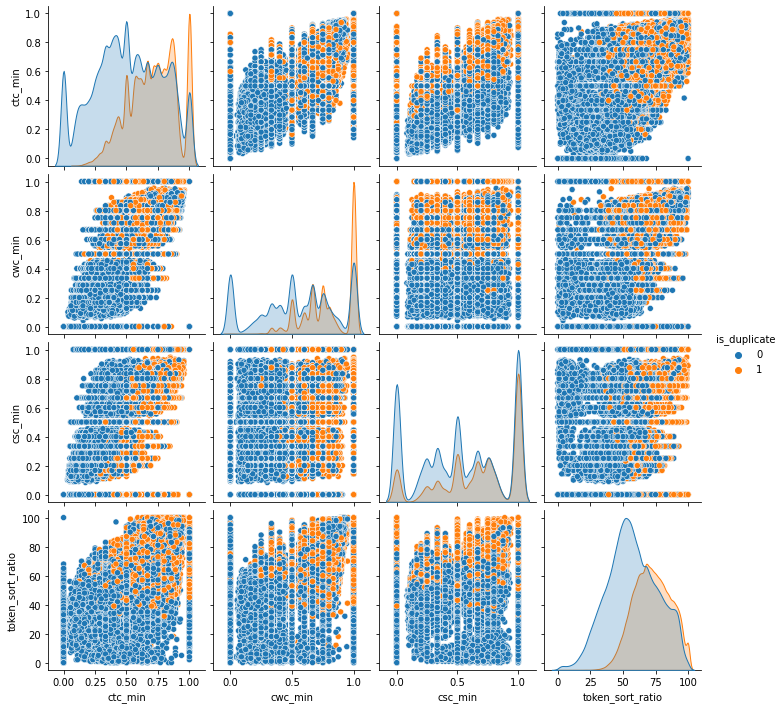

In [55]:
n = data.shape[0]
sns.pairplot(data[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n],hue='is_duplicate',vars= ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

# 5.3 Violin Plots


## 5.3.1 Token Sort Ratio

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


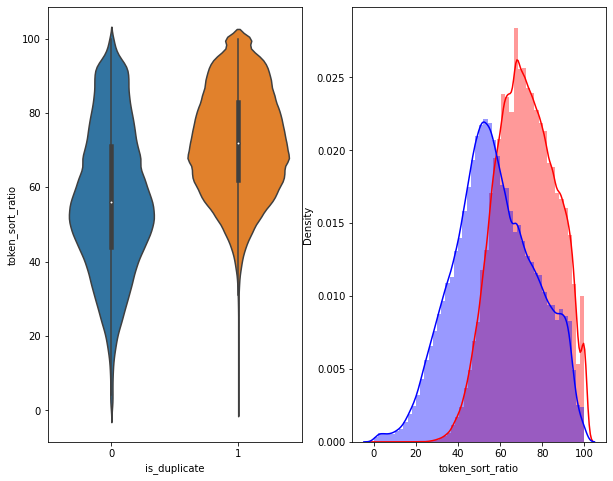

In [56]:
plt.figure(figsize=(10, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = data[0:] , )
plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

## 5.3.2 Fuzz Ratio


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


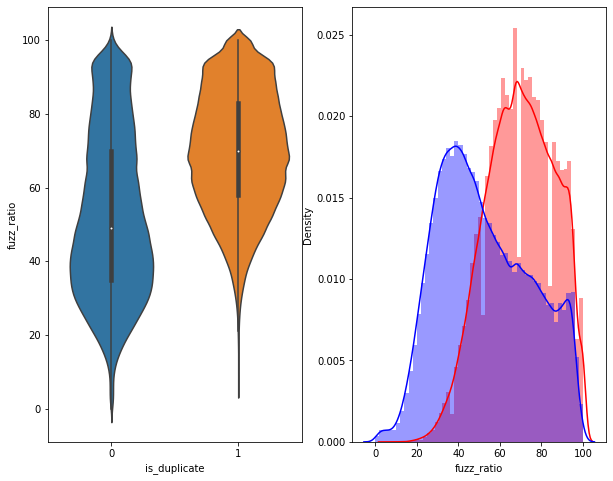

In [57]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = data[0:] , )

plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

# 6. Word Embeddings

For word embeddings we are going to use spacy pretrained Glove model.

https://spacy.io/usage/vectors-similarity

In [4]:
!unzip drive/MyDrive/qoura/advance_features.zip

Archive:  drive/MyDrive/qoura/advance_features.zip
  inflating: advance_features.csv    


In [5]:
data = pd.read_csv('advance_features.csv')

In [15]:
targets = data['is_duplicate']

In [2]:
nlp =  spacy.load('en_core_web_md')

In [8]:
questions = list(data['question1'].values.astype(str)) + list(data['question2'].values.astype(str))

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [9]:
# intializing tokenizer 
tokenzr = Tokenizer()

# genrating vocab
tokenzr.fit_on_texts(questions)

#converting text into integer sequences
q1 = tokenzr.texts_to_sequences(data['question1'].values.astype(str)) 
q2 = tokenzr.texts_to_sequences(data['question2'].values.astype(str))

#padding to prepare sequences of same length
q1 = pad_sequences(q1, maxlen=100)
q2 = pad_sequences(q2, maxlen=100)


In [10]:
vocab = tokenzr.word_index
embedding_dim = 300 # Using en_core_web_md has only 300 vectors
embedding_matrix = np.zeros((len(vocab), embedding_dim))

for i, word in tqdm(enumerate(vocab), total= len(vocab)):
    embedding_matrix[i] = nlp(word).vector


100%|██████████| 85666/85666 [08:06<00:00, 175.96it/s]


In [18]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *

In [27]:

model=Sequential()

#embedding layer
model.add(Embedding(len(vocab),300,weights=[embedding_matrix],input_length=100,trainable=False)) 

#lstm layer
model.add(LSTM(128,return_sequences=True,dropout=0.2))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(64,activation='relu')) 
model.add(Dense(1,activation='sigmoid')) 

#Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["acc"]) 



#summary of model
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 300)          25699800  
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 128)          219648    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 25,927,769
Trainable params: 227,969
Non-trainable params: 25,699,800
_________________________________________________________________
None


In [29]:
model.fit([q1, q2], targets, epochs=10, validation_split=0.3, shuffle=True, )

Epoch 1/10
8844/8844 [==============================] - 91s 10ms/step - loss: 0.5874 - acc: 0.6892 - val_loss: 0.5465 - val_acc: 0.7246
Epoch 2/10
8844/8844 [==============================] - 88s 10ms/step - loss: 0.5323 - acc: 0.7344 - val_loss: 0.5296 - val_acc: 0.7375
Epoch 3/10
8844/8844 [==============================] - 88s 10ms/step - loss: 0.5126 - acc: 0.7479 - val_loss: 0.5142 - val_acc: 0.7492
Epoch 4/10
8844/8844 [==============================] - 89s 10ms/step - loss: 0.4964 - acc: 0.7583 - val_loss: 0.5068 - val_acc: 0.7530
Epoch 5/10
8844/8844 [==============================] - 88s 10ms/step - loss: 0.4833 - acc: 0.7660 - val_loss: 0.5058 - val_acc: 0.7548
Epoch 6/10
8844/8844 [==============================] - 88s 10ms/step - loss: 0.4733 - acc: 0.7737 - val_loss: 0.5039 - val_acc: 0.7567
Epoch 7/10
8844/8844 [==============================] - 88s 10ms/step - loss: 0.4658 - acc: 0.7761 - val_loss: 0.5038 - val_acc: 0.7586
Epoch 8/10
8844/8844 [==========================